# Домашнее задание №6

Задание присылать на обе почты почты aleksartamonov@gmail.com dashkov.alexander.om@gmail.com в виде ссылки на colab

В теме письма указать **CV_HSE_2021 HW6 <Фамилия Имя>**

soft deadline: 23.06.2020T23:59:00+0300

hard deadline: 30.06.2020T23:59:00+0300

In [1]:
# from google.colab import drive
# drive.mount('/gdrive')
# %cd /gdrive/MyDrive/Corel-10k/
# %ls

# Поиск изображений по содержанию (30 (+20) баллов)

Вам предстоит построить систему, которая позволит выполнить поиск изображений по содержанию в базе Corel-10k, которая приложена к домашнему заданию. База состоит из 100 классов изображений по 100 изображений в каждом классе. Имя каждого изображения в базе состоит из **X.JPEG**, где X - число от 1 до 10000. Изображения из одного класса лежат подряд в промежутке 1-100, 101-200, и тд. В файле **test.dat** лежит список картинок, которые не должны участвовать в построении поисковой базы, но по которым надо будет сделать 1000 поисковых запросов. Ограничение по памяти -- 2Гб.

1. По изображениям не попавшим в **test.dat** посчитайте дескриптор с помощью алгоритма GIST.
   
2. Разбейте дескрипторы всех изображений на 100 кластеров с помощью K-Means.

3. Для каждого кластера постройте функцию хэширования (LSH), с помощью которой закодируйте каждое изображение в тренировочной выборке.

5. Релизуйте функцию `retrieve` продемонстрируйте работу `retrieve` на 5-ти случайных изображениях из **test.dat**. Замерьте время исполнения поискового запроса. Сделайте возможность вызвать `retrieve` без построения индекса, то есть приложите в решение индексированную базу, если только время построения индекса не укладывается в 1 минуту.  

5. Сделайте 1000 запросов изображениями из файла **test.dat**.  Замерьте среднее время исполнения поискового запроса в colab ноутбуке.

    
6. Для каждого запроса нужно оценить AP@k, где k=10 и посчитать среднее значение этой величины по всем запросам (MAP). Формулу берем из этой презентации: https://web.stanford.edu/class/cs276/handouts/EvaluationNew-handout-1-per.pdf

Так же за это задание можно получить еще до 20-ти дополнительных баллов. 

1. Вы можете сделать быстрый поиск. Если качество вашего поиска окажется выше, чем медиана качества по всем поисковым движкам, то вы принимаете участие в 
борьбе за 10 призовых баллов. Первое место получает 10 баллов, второе 9, третье 8 и т.д. 

2. Вы можете сделать хороший поиск. Если ваш поиск окажется быстрее, чем медиана среднего времени работы других участников, то вы принимаете участие в борьбе за точный поиск. Распределение баллов здесь будет такое же как и в конкурсе на скорость. 

Для достижения лучших результатов вам придется регулировать несколько параметров алгоритма:
- Дескриптор. Можете взять что угодно вместо GIST
- Количество кластеров k-means
- Длину кода LSH
- etc 

Принципиально нельзя использовать готовые поисковые движки (annoy, faiss, etc, ..). И помните о том, что время поиска – очень важный параметр.
В случае использования нейросети инференс картинки производите без GPU ускорителя. Для обучения использовать GPU можно. Безусловно **не используйте изобржения из test.dat для обучения сети или построения поисковой базы**. 



---



Для итогового отчета посторойте таблицу в которой будет указано имя метода, значение MAP для этого метода, среднее время работы функции `revtrive` оцененное через утилиту `timeit` внутри GoogleCollab. (Базу вы можете построить на персональном копьютере.)

In [2]:
import os, cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from numpy.lib import stride_tricks
from joblib import delayed, Parallel
import pickle

In [3]:
class LshCode:
    def __init__(self, centroids, descriptors, length):
        self.centroids = centroids
        self.length = length
        
        # points = (descriptors - centroids).copy()
        points = descriptors.copy()
        
        self.norm_array = np.random.uniform(-100, 100, (self.length, points.shape[1]))
        self.norm_array /= np.linalg.norm(self.norm_array, axis=1).reshape(-1,1)
        self.c = np.random.normal(0, np.median(np.std(points, 0)), self.length)
        
        self.lsh_codes = np.zeros((self.length, len(points)))
        for i in range(self.length):
            self.lsh_codes[i] = points.dot(self.norm_array[i]) + self.c[i] > 0
        self.lsh_codes = self.lsh_codes.T
        
    def create_lsh_code(self, point):
        # p = (point -  self.centroids).copy()
        p = point.copy()
        lsh_code = np.zeros(self.length)
        for i in range(self.length):
            lsh_code[i] = p.dot(self.norm_array[i]) + self.c[i] > 0
        return lsh_code
    
    
def gabour_bank(phi_bins, scale_bins, max_scale, min_scale, sigma_scale=0.5, psi=0):
    """
    Parameters:
    size (tuple|int): Size or radius of filters.
    phi_bins (int): Number of angle beens of bank
    scale_bins (int): Number of scales betwwen max_scale and min_scale
    max_scale (float): Max frequency covered by bank
    min_scale (float): Min frequency covered by bank
    Returns:
    list: a list of filters
    """

    lambdas = np.linspace(min_scale, max_scale, scale_bins)
    thetas = np.linspace(0, np.pi, phi_bins, endpoint=False)
    filters = []
    for theta in thetas:
        for lam in lambdas:
            size_ = int(1.5 * lam)
            sigma = sigma_scale * lam
            kernel = cv2.getGaborKernel((size_, size_), sigma, theta, lam, gamma=1, psi=psi)
            kernel /= np.sqrt((kernel * kernel).sum())
            filters.append(np.copy(kernel))
    return filters


class Gist:
    def __init__(self, filters, phi_bins=6, scale_bins=5, window_size = 4):
        self.win = window_size
        self.w = phi_bins
        self.h = scale_bins
        self.filters = filters

    def get_gist_descriptor(self, image):
        h, w, c = image.shape
        
        res = np.zeros((self.h * h, self.w * w, c), dtype = 'float')
        res1 = np.zeros((self.h * self.win, self.w * self.win, c), dtype = 'float')

        descriptor = []

        for i in range(self.h):
            for j in range(self.w):
                temp = cv2.filter2D(image, -1, self.filters[self.w * i + j])
                res[i * h:(i + 1) * h, j * w:(j + 1) * w] = \
                    cv2.normalize(temp, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
                for y in range(self.win):
                    for x in range(self.win):
                        res1[i * self.win + y, j * self.win + x] = \
                            np.mean(res[i * h + int(y * h / self.win):i * h + int((y + 1) * h / self.win), 
                                        j * w + int(x * w / self.win):j * w + int((x + 1) * w / self.win)], 
                                    axis = (0, 1))
                descriptor.extend(res1[i * self.win:(i + 1) * self.win, 
                                       j * self.win:(j + 1) * self.win].flatten())
        return np.array(descriptor)
    
    
class MyDataset:
    def __init__(self, imgs_name, resize=False):
        self.photo_names = imgs_name
        self.resize = resize
    
    def __getitem__(self, index):
        img = cv2.imread(self.photo_names[index])
        if self.resize:
            img = cv2.resize(img, (128, 128))
        return img
    
    def __len__(self):
        return len(self.photo_names)

In [4]:
# Extract train/test imgs

base_path = "Corel-10k"
img_paths = os.listdir(f"{base_path}/Images")

imgs_train = []
imgs_test = []

with open(f"{base_path}/test.dat", "r") as test:
  for test_img in test.readlines():
    imgs_test.append(test_img.strip())

for img in img_paths:
  if img  not in imgs_test:
    imgs_train.append(f"{base_path}/Images/" + img)
    
imgs_test = [f"{base_path}/Images/" + img for img in imgs_test]

train_ids = np.array([int(os.path.basename(img)[:-4]) for img in imgs_train])
test_ids = np.array([int(os.path.basename(img)[:-4]) for img in imgs_test])

train_ds = MyDataset(imgs_train, resize=False)
test_ds = MyDataset(imgs_test, resize=False)
print(len(train_ds), len(test_ds))

9000 1000


64


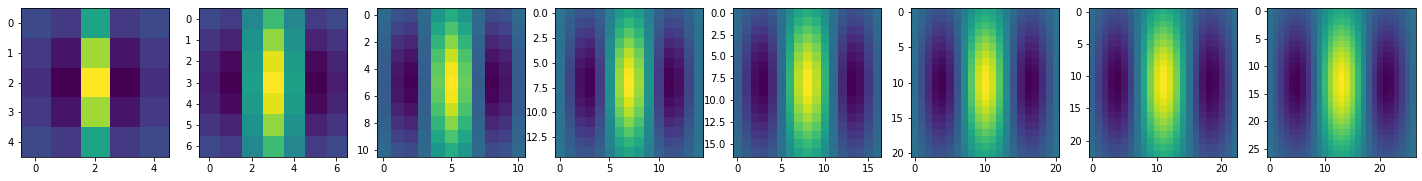

In [5]:
# Get array of filters
scale_bins = 8
phi_bins = 8
filters = gabour_bank(phi_bins=phi_bins, scale_bins=scale_bins, max_scale=18, min_scale=3, sigma_scale=0.5)
print(len(filters))
plt.figure(figsize=(25, 5))
for i, flt in enumerate(filters[:scale_bins]):
    plt.subplot(1, scale_bins, i + 1)
    plt.imshow(flt)

In [6]:
gist = Gist(filters, phi_bins=phi_bins, scale_bins=scale_bins, window_size=5)

get_emb = delayed(gist.get_gist_descriptor)

if os.path.exists("train_embeddings.npy"):
    train_embeddings = np.load("train_embeddings.npy")
else:
    train_embeddings = np.array(Parallel(n_jobs=8)(get_emb(img) for img in train_ds))
    np.save("train_embeddings.npy", train_embeddings)
    
if os.path.exists("test_embeddings.npy"):
    test_embeddings = np.load("test_embeddings.npy")
else:
    test_embeddings = np.array(Parallel(n_jobs=8)(get_emb(img) for img in test_ds))
    np.save("test_embeddings.npy", test_embeddings)
    
print(train_embeddings.shape, test_embeddings.shape)

(9000, 4800) (1000, 4800)


In [7]:
num_clusters = 100

if os.path.exists("kmeans.pkl"):
    with open("kmeans.pkl", "rb") as km:
        kmeans = pickle.load(km)
else:
    kmeans = KMeans(n_clusters=num_clusters, n_init=50)
    kmeans.fit(train_embeddings)

    with open("kmeans.pkl", "wb+") as km:
        pickle.dump(kmeans, km)
        
cluster_ids = kmeans.labels_
centroids = kmeans.cluster_centers_
print(centroids.shape)

(100, 4800)


In [8]:
lsh_len = 10
lsh_array = []
for cluster in range(num_clusters):
    lsh_array.append(LshCode(centroids[cluster], train_embeddings[cluster == cluster_ids], length=lsh_len))

In [9]:
def retrive(img, gist, kmeans, train_embeddings, lsh_array, train_ids, k=10):
    cluster_ids = kmeans.labels_
    centroids = kmeans.cluster_centers_
    lsh_length = lsh_array[0].length
    num_clusters = centroids.shape[0]
    
    cur_point = gist.get_gist_descriptor(img)

    cluster_distance = np.apply_along_axis(lambda x: np.linalg.norm(cur_point - x), 1, centroids)

    res_positions = np.zeros(train_embeddings.shape[0], dtype=bool)
    nearest_clusters = np.argsort(cluster_distance)[:int(0.1 * num_clusters)]

    for cur_cluster in nearest_clusters:
        cur_lsh = lsh_array[cur_cluster]
        point_lsh = cur_lsh.create_lsh_code(cur_point) 
        res_positions[cluster_ids == cur_cluster] = \
            np.sum(np.abs(cur_lsh.lsh_codes - point_lsh), 1) < int(0.5 * lsh_length) 

    res_points = train_embeddings[res_positions]
    res_distance = np.apply_along_axis(lambda x: np.linalg.norm(cur_point - x), 1, res_points)

    k_nearest_position = train_ids[res_positions][np.argsort(res_distance)[:k]]
    return k_nearest_position

def apk(point_class, k_nearest_class):
    true_position = np.where(k_nearest_class == point_class)[0]
    ap = 0
    if len(true_position) > 0:
        for i in range(len(true_position)):
            ap += (i + 1) / (true_position[i] + 1)
        ap /= len(true_position)
    return ap

In [10]:
%%timeit

img = test_ds[0]
k_nearest = retrive(img, gist, kmeans, train_embeddings, lsh_array, train_ids, k=10) // 100
point_class = test_ids[0] // 100
_ = apk(point_class, k_nearest)

106 ms ± 210 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [11]:
# %%timeit
# Это не распараллелинное вычисление
ap_array = []
for idx, img in enumerate(test_ds):
    k_nearest = retrive(img, gist, kmeans, train_embeddings, lsh_array, train_ids, k=10) // 100
    point_class = test_ids[idx] // 100
    ap_array.append(apk(point_class, k_nearest))
print(np.mean(ap_array))

0.4944002765180146


Времена в целом совпадают, если усреднить по размеру датасета. Так как timeit не выдал предупреждения о возможном кэширровании (т.е. самый медленный прогон проходит примерно за столько же, сколько и самый быстрый), то можно судить о том, что кэширования на самом деле не происходило (по крайней мере локально у меня все ок работает, на колабе почему-то все ломается, и даже MAP сваливается на порядок меньше, вероятно, пиклы как-то криво подгружаются)

# HPO

In [12]:
def pipeline(cfg):
    def retrieve(index, k = 10):
        cur_point = test_embeddings[index]

        cluster_distance = np.apply_along_axis(lambda x: np.linalg.norm(cur_point - x), 1, centroids)

        res_positions = np.zeros(train_embeddings.shape[0], dtype=bool)
        nearest_clusters = np.argsort(cluster_distance)[:int(0.1 * num_clusters)]

        for cur_cluster in nearest_clusters:
            cur_lsh = lsh_array[cur_cluster]
            point_lsh = cur_lsh.create_lsh_code(cur_point) 
            res_positions[cluster_ids == cur_cluster] = \
                np.sum(np.abs(cur_lsh.get_lsh_codes() - point_lsh), 1) < int(0.5*cfg["lsh_length"]) 

        res_points = train_embeddings[res_positions]
        res_distance = np.apply_along_axis(lambda x: np.linalg.norm(cur_point - x), 1, res_points)

        k_nearest_position = train_ids[res_positions][np.argsort(res_distance)[:k]]
        return k_nearest_position
    
    
    def apk(index, retrieve=retrieve, k = 10):
        cur_pos = test_ids[index]
        point_class = cur_pos // 100
        
        k_nearest_class = retrieve(index, k=k) // 100
        
        true_position = np.where(k_nearest_class == point_class)[0]
        ap = 0
        if len(true_position) > 0:
            for i in range(len(true_position)):
                ap += (i + 1) / (true_position[i] + 1)
            ap /= len(true_position)
        return ap
    
    
    get_ap = delayed(apk)
    
    
    filters = gabour_bank(phi_bins=cfg["phi_bins"], scale_bins=cfg["scale_bins"], 
                          max_scale=cfg["max_scale"], min_scale=cfg["min_scale"], 
                          sigma_scale=cfg["sigma_scale"])
    
    gist = Gist(filters, phi_bins=cfg["phi_bins"], scale_bins=cfg["scale_bins"], 
                window_size=cfg["window_size"])

    get_emb = delayed(gist.get_gist_descriptor)

    train_embeddings = np.array(Parallel(n_jobs=8)(get_emb(img) for img in train_ds))
    test_embeddings = np.array(Parallel(n_jobs=8)(get_emb(img) for img in test_ds))
    
    kmeans = KMeans(n_clusters=cfg["num_clusters"], n_init=50)
    kmeans.fit(train_embeddings)
    cluster_ids = kmeans.labels_
    centroids = kmeans.cluster_centers_
    
    lsh_array = []
    for cluster in range(cfg["num_clusters"]):
        lsh_array.append(LshCode(centroids[cluster], train_embeddings[cluster == cluster_ids], 
                                 length=cfg["lsh_length"]))
        
    get_ap = delayed(apk)
    gist_map = np.mean(np.array(Parallel(n_jobs=8)(get_ap(i, retrieve) for i in range(test_embeddings.shape[0]))))
    # naive_map = np.mean(np.array(Parallel(n_jobs=8)(get_ap(i, retrieve_naive) for i in range(test_embeddings.shape[0]))))
    naive_map = -1
        
    return gist_map, naive_map
    

In [13]:
cfgs = []

cfg_base = {
    "size": 11,
    "phi_bins": 6,
    "scale_bins": 5,
    "max_scale": 18,
    "min_scale": 3,
    "sigma_scale": 0.5,
    "window_size": 4,
    "num_clusters": 100,
    "lsh_length": 10,
}

for phi_bins in (4, 6, 8):
    for scale_bins in (3, 5, 7):
        for max_scale in (18,):
            for min_scale in (3,):
                for sigma_scale in (0.1, 0.3, 0.5,):
                    for windows_size in (4, 5):
                        for num_clusters in (100,):
                            for lsh_length in (10,):
                                cfgs.append({
                                    "size": 11,
                                    "phi_bins": phi_bins,
                                    "scale_bins": scale_bins,
                                    "max_scale": max_scale,
                                    "min_scale": min_scale,
                                    "sigma_scale": sigma_scale,
                                    "window_size": windows_size,
                                    "num_clusters": num_clusters,
                                    "lsh_length": lsh_length,
                                })


In [14]:
# import pprint
# from tqdm.notebook import tqdm

# naive_map_best = 0
# gist_map_best = 0
# for cfg in tqdm(cfgs):
#     pprint.pprint(cfg)
#     gist_map, naive_map = pipeline(cfg)
#     if gist_map > gist_map_best:
#         gist_map_best = gist_map
#         gist_cfg = cfg.copy()
#     if naive_map > naive_map_best:
#         naive_map_best = naive_map
#         naive_cfg = cfg.copy
#     print(gist_map, naive_map)

# pprint.pprint(gist_cfg)
# print()
# pprint.pprint(naive_cfg)